In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats

import datetime as dt 
from scipy.stats import kendalltau, pearsonr, spearmanr
import math
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import bernoulli
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.distributions.empirical_distribution import ECDF
# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}


# # use these to format date axis in charts
# weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
# # onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
# # everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

# months = mdates.MonthLocator(bymonth=[3,6,9,12])
# bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
# allmonths = mdates.MonthLocator()
# wks_fmt = mdates.DateFormatter('%d')
# mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False


# collect the names:
# group_names = list(these_groups.keys())

# choose a lake:
# lake = 'Lac Léman'
coi = 'Neuchâtel'
bassin_label = 'Aare'
bassin = ['Aare', 'Aare|Nidau-Büren-Kanal','Schüss', 'Neuenburgersee', 'Thunersee','Bielersee', 'Brienzersee','La Thièle']
bassin_lmn = ['Rhône', 'Lac Léman']
samples_all = 'All samples'
# lavey_locs= ['lavey-les-bains-2','lavey-les-bains', 'lavey-la-source']


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'bielsummary'
save_output = False

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# get the data
# aggregated survey data
# dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")

# keep track of output
files_generated = []
figure_num = 1
data_num = 1

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [3]:
# non aggregated survey data
# Zero values are assigned for all codes not identified at a survey, for each survey
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# allow for groups
dfSurveys['groupname'] = 'nogroup'



In [4]:
# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

In [5]:
group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}


frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}
levels={'muni':coi, 'catchment':bassin_label}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']
catchment_cols = ['region','water_name','type','city','loc_date', 'location', 'date']
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

In [6]:
data = dfSurveys.copy()
data.set_index('location', inplace=True)

In [7]:
lakes = dfBeaches.water == 'l'
rivers = dfBeaches.water == 'r'
bssn = dfBeaches.water_name.isin(bassin)

data['type'] = 't'
data.loc[lakes, 'type'] = 'l'
data.loc[rivers, 'type'] = 'r'

In [8]:
data.reset_index(inplace=True)
a = ac.PreprocessData(data, dfBeaches,these_cols=these_cols, foams=foams, start_date=start_date, end_date=end_date)

clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    catchment_features=bassin,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=catchment_cols)


code maps done
agg foams complet
added exp vs


In [9]:
b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

made code groups
making group map
assigned results to code groups
assigned regional labels
assigned results to code groups
assigned regional labels
made code totals
made code totals


In [10]:
clas_kwargs.update({'catchment_features':bassin_lmn})
clas_kwargs.update({'muni':'Préverenges', 'catchment':"Rhône Léman"})
c = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

made code groups
making group map
assigned results to code groups
assigned regional labels
assigned results to code groups
assigned regional labels
made code totals
made code totals


In [11]:
som_bassin_data = b.bassin_data.copy()

# mark all the records that have quantity > 0
som_bassin_data['fail'] = som_bassin_data.quantity > 0
print(som_bassin_data.columns)

Index(['location', 'date', 'code', 'pcs_m', 'quantity', 'loc_date',
       'water_name', 'groupname', 'type', 'population', 'string_date',
       'region', 'city', 'fail'],
      dtype='object')


In [12]:
# map number of samples per location and sample total of all objects to each record

def add_attribute(x, a_map={}):
    try:
        num_samps = a_map[x]
    except:
        num_samps = 0
    return num_samps

# conut the number of samples per location
num_samp_location = b.bassin_pcsm_day.groupby('location').loc_date.count()

# retrieve the total quantity per sample
qty_sample = b.bassin_pcsm_day.groupby('loc_date').quantity.sum()

In [13]:
# map values to bassin data

# the number of samples at a location
for beach in som_bassin_data.location.unique():
    som_bassin_data.loc[som_bassin_data.location==beach, 'nsamps'] = add_attribute(beach, a_map=num_samp_location)

# the number of samples at a location divided by the total number of samples
som_bassin_data['l_weight'] = som_bassin_data.nsamps/len(som_bassin_data.loc_date.unique())

# the survey total for the corresponding loc_date variable
for loc_date in som_bassin_data.loc_date.unique():
    som_bassin_data.loc[som_bassin_data.loc_date==loc_date, 'samp_total'] = qty_sample[[loc_date]][0]

# the % of total for that object for the survey defined by loc_date
som_bassin_data['% of total'] = som_bassin_data.quantity/som_bassin_data.samp_total

In [14]:


def save_describe(x):
    data=x.describe()
    return data.values

# save the key values from the original data:
q_before = save_describe(som_bassin_data.quantity)
pc_befor = save_describe(som_bassin_data.pcs_m)
print(som_bassin_data.quantity.sum())

12364


In [15]:
# rank the quantity found of each code in each survey for all locations
ranked = []

# the loc_date values to aggregate:
locs = som_bassin_data.loc_date.unique()

In [16]:
som_bassin_data.quantity.describe()

count    27846.000000
mean         0.444014
std          3.323533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        161.000000
Name: quantity, dtype: float64

In [17]:
som_bassin_data.pcs_m.describe()

count    27846.000000
mean         0.010386
std          0.078624
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.230000
Name: pcs_m, dtype: float64

In [18]:
# for each value in loc_date:
sbd = som_bassin_data.copy()
for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd[sbd.loc_date == a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['rank'] = sbdl.index
    ranked.append(sbdl)
    
# new data with amplitude rankings for each record
som_bassin_data = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print(q_before == som_bassin_data.quantity.describe().values)
print(som_bassin_data.quantity.sum())
print(pc_befor == som_bassin_data.pcs_m.describe().values)


[ True  True False  True  True  True  True  True]
12364
[ True  True  True  True  True  True  True  True]


In [19]:
# group by code and location. keep the columns that are specific to the location
# agg results: pieces per meter and quantity. count the number of samples for this code and location
sbd_ranked = som_bassin_data.groupby(['code','rank','location', 'population', 'groupname','l_weight','type'], as_index=False).agg({'pcs_m':'median', 'loc_date':'count', 'quantity':'sum'})

# recalculate the % of total for the group levels
# the sum of this col should equal one
sbd_ranked['% of total'] = sbd_ranked.quantity/sbd_ranked.quantity.sum()

# house keeping
# the number of surveys is equal to the number of unique loc_values
sbd_ranked.rename(columns={'loc_date':'n_times'}, inplace=True)

# calculate the weight of the sample in reference to all other samples
# the sum of rank_weight should equal one
sbd_ranked['n_weight'] = sbd_ranked.n_times/len(locs)

print(F"Check the n_weight sum:{sbd_ranked.n_weight.sum()}\n\nCheck the % of total column: {sbd_ranked['% of total'].sum()}\n")

print(F"The number of times that G27 is ranked one: {len(som_bassin_data[(som_bassin_data.code == 'G27')&(som_bassin_data['rank'] == 1)])}\n")

# aggregate and check:
rank_and_code = sbd_ranked.groupby(['rank','code','location'], as_index=False).n_times.sum()
print(F"The aggregated values should be the same: {rank_and_code[(rank_and_code.code == 'G27')&(rank_and_code['rank'] == 1)].n_times.sum()}\n")

print(F"The locations where G27 was number one at least once: \n\n{rank_and_code[(rank_and_code.code == 'G27')&(rank_and_code['rank'] == 1)].location.unique()}")
print(F"\nG27 has been the number one at least once at {np.round((len(rank_and_code[(rank_and_code.code == 'G27')&(rank_and_code['rank'] == 1)].location.unique())/len(som_bassin_data.location.unique())*100),0)}% of the locations sampled")

print(F"\nG27 has been the number one object at a survey {np.round((len(som_bassin_data[(som_bassin_data.code == 'G27')&(som_bassin_data['rank'] == 1)])/len(som_bassin_data.loc_date.unique()))*100, 0)}% of the time\n" )

Check the n_weight sum:220.99999999999997

Check the % of total column: 1.0

The number of times that G27 is ranked one: 47

The aggregated values should be the same: 47

The locations where G27 was number one at least once: 

['aare-solothurn-lido-strand' 'aare_brugg_buchie' 'aare_koniz_hoppej'
 'aare_post' 'camping-gwatt-strand' 'evole-plage' 'hafeli'
 'hauterive-petite-plage' 'la-petite-plage' 'mullermatte'
 'plage-de-cheyres' 'ruisseau-de-la-croix-plage' 'schusspark-strand'
 'sundbach-strand' 'thun-strandbad' 'weissenau-neuhaus']

G27 has been the number one at least once at 36.0% of the locations sampled

G27 has been the number one object at a survey 37.0% of the time



In [20]:
other_number_one_ranks = rank_and_code[rank_and_code['rank'] == 1].groupby(['code','location'], as_index=False).n_times.sum()
print(F"Codes and the number of times that they have been the number one item at a survey\n{other_number_one_ranks.groupby('code').n_times.sum().sort_values(ascending=False)}")

Codes and the number of times that they have been the number one item at a survey
code
G27     47
G200    17
G78     12
G30      9
G81      7
G79      7
G67      7
G117     3
G941     2
G98      2
G74      2
G33      1
G213     1
G208     1
G203     1
G201     1
G87      1
G178     1
G146     1
G131     1
G923     1
G112     1
Name: n_times, dtype: int64


In [21]:
# project directory is 'output/bielsummary'
sbd_ranked.to_csv(F"{project_directory}/aare_codes_ranked.csv")

In [22]:
these_codes = ['G27', 'G30','G25', 'G81', 'G95', 'G67','G82']

In [23]:
# grouped by survey and code group
sbd_ranked_gs = som_bassin_data.groupby(['loc_date','groupname','location', 'population'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

sbd_ranked_gs['% of total'] = sbd_ranked_gs.apply(lambda x: x.quantity/qty_sample[x.loc_date], axis=1)
# save the key values from the original data:
q_before = save_describe(sbd_ranked_gs.quantity)
pc_befor = save_describe(sbd_ranked_gs.pcs_m)
print(sbd_ranked_gs.quantity.sum())

12364


In [24]:
ranked = []
for a_samp in locs:
    sbdl = sbd_ranked_gs[sbd_ranked_gs.loc_date == a_samp].sort_values(by='% of total', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['rank'] = sbdl.index
    ranked.append(sbdl)
    
sbd_ranked_gs = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print("Check that the survey values have not been altered:\n")
print(q_before == sbd_ranked_gs.quantity.describe().values)
print(pc_befor == sbd_ranked_gs.pcs_m.describe().values)

# check the % of total
print(F"\nCheck % of total: {sbd_ranked_gs.groupby('loc_date')['% of total'].sum().sum()}\n")
print(F"The number of SURVEYS where ALL TOBACCO items combined are rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()}\n")

print(F"All TOBACCO items combined were number one in {np.round((sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()/sbd_ranked_gs.loc_date.nunique())*100,0)}% of the surveys.")
print(F"\nThe number of locations that tobaco is rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].location.nunique()}\n")
print(F"The objects labeled tobacco:\n{sbd_ranked[sbd_ranked.groupname == 'tobacco'].code.unique()}")

Check that the survey values have not been altered:

[ True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True]

Check % of total: 126.0

The number of SURVEYS where ALL TOBACCO items combined are rank one: 33

All TOBACCO items combined were number one in 26.0% of the surveys.

The number of locations that tobaco is rank one: 11

The objects labeled tobacco:
['G152' 'G25' 'G26' 'G27']


In [25]:
f = sbd_ranked_gs.groupby(['rank','groupname','location'], as_index=False).loc_date.nunique()
fx = f[f['rank'] == 1].groupby('groupname').loc_date.sum()
print(F"\nThe number of samples: {fx.sum()}\n")
print(F"Other groups and the number of times they have been the most prevalent item:\n{fx.sort_values(ascending=False)}\n")


The number of samples: 126

Other groups and the number of times they have been the most prevalent item:
groupname
food                   45
tobacco                33
fragmented plastics    19
construction           14
agg-con-trans           5
less than 5mm           3
waste water             2
the rest                2
recreation              2
packaging               1
Name: loc_date, dtype: int64



In [26]:
# get the pass fail rate for each water feature

# the total number of tries:
tries_t = som_bassin_data.groupby(['water_name', 'code']).loc_date.nunique()

# the total number of times that the object was found for a particular water feature
fails_b = som_bassin_data.groupby(['water_name','code']).fail.sum()

# the total number of samples:
n_samps_b = som_bassin_data.groupby(['water_name']).loc_date.nunique()

In [27]:
# get all values greater than zero for each code and LOCATION
grtr_than_zero = som_bassin_data[(som_bassin_data.quantity > 0)].groupby(['code', 'location'], as_index=False).loc_date.count()

# weight the result by the sum of the loc_date column
grtr_than_zero['weight'] = grtr_than_zero.loc_date/grtr_than_zero.loc_date.sum()

# housekeeping
som_data = som_bassin_data.copy()

# get a list of the codes that were found at least once
codes_in_use = grtr_than_zero.code.unique()

In [28]:
# combine the tries and fails dfs for each water feature
tries_fails_b = pd.concat([tries_t, fails_b], axis=1)
tries_fails_b.reset_index(inplace=True)

In [29]:
tries_fails_b.iloc[:3]

,water_name,code,loc_date,fail
0,Aare,G1,12,0
1,Aare,G10,12,0
2,Aare,G100,12,0


In [30]:
# get the ratio of total tries per code and location to total number of samples for that feature
for a_b in tries_fails_b.water_name.unique():
    tries_fails_b.loc[tries_fails_b.water_name==a_b, 'rate'] = tries_fails_b.fail/n_samps_b.loc[a_b]

tries_fails_b.iloc[:3]

,water_name,code,loc_date,fail,rate
0,Aare,G1,12,0,0.0
1,Aare,G10,12,0,0.0
2,Aare,G100,12,0,0.0


In [31]:
# the minimum rate is 1/ the current sample number + 1
# we are assuming that if the object has never been found before there
# is always a chance that we may find it on the next sample
# the longer we go without finding it the less likely it is to find in the river basin
# which means that once it has been identified this should be considered a significant event.
rate_min = 1/(len(a.processed.loc_date.unique())+1)
rate_min

0.002898550724637681

In [32]:
tries_fails_b.loc[tries_fails_b.fail==0, 'min_rate'] = rate_min
tries_fails_b.loc[tries_fails_b.fail>0, 'min_rate'] = tries_fails_b.rate
tries_fails_b.iloc[:3]

,water_name,code,loc_date,fail,rate,min_rate
0,Aare,G1,12,0,0.0,0.002899
1,Aare,G10,12,0,0.0,0.002899
2,Aare,G100,12,0,0.0,0.002899


In [33]:
# get the ratio samples-per-location/number-samples-catchment-area
weights = tries_fails_b[['water_name', 'loc_date']].drop_duplicates().set_index('water_name', drop=True)
weights['location_weight'] = weights.loc_date/len(locs)
nsamps = weights.loc['Aare', :]

# now the number of samples and the weight is available
nsamps

loc_date           12.000000
location_weight     0.095238
Name: Aare, dtype: float64

In [34]:
# pull some samples from one river basin feature
feature = 'Aare'
n = weights.loc['Aare', 'loc_date']
rates = tries_fails_b.loc[tries_fails_b.water_name == 'Aare'][['code','min_rate']].set_index('code')

# store the samples here
theta_samples_feature = pd.DataFrame(index=codes_in_use)

In [35]:
rates.loc['G27'].values

array([0.5])

In [36]:
# determine wehter or not an object was found at a survey
# use the rates for the parameter of a bernouli trial for each code

k=0
for j in np.arange(n):
    k+=1
    col_name = F"s_{int(k)}"
    for a_code in codes_in_use:
        theta_samples_feature.loc[a_code, col_name ] = bernoulli.rvs(rates.loc[a_code], size=1)


found_feature = theta_samples_feature > 0
codes_found_feature = [found_feature[found_feature[s_one] == True][s_one].index for s_one in found_feature.columns]
codes_found_len_feature = [len(x) for x in codes_found_feature]

In [37]:
d_samps_aare = b.bassin_data[(b.bassin_data.quantity>0)&(b.bassin_data.water_name == "Aare")][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [38]:
# get the number of times each code was found
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
theta_codes_count = count_occurences(codes_found_feature)
dsamp_aare_count = pd.DataFrame(count_occurences(d_samps_aare)).set_index('code')

In [39]:
dsamp_aare_count.loc['G7', 'inst']

2

In [40]:
# combine the counts in to one dataframe and compare results

def combine_code_counts(x):
    try:
        data = dsamp_aare_count.loc[x, 'inst']
    except:
        data = 0
    return data
        
theta_codes = pd.DataFrame(theta_codes_count)
theta_codes['s_inst'] = theta_codes.code.map(lambda x: combine_code_counts(x))
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

# check the diffference between the two sets
print(theta_codes['s_inst'].sum())
print(theta_codes['inst'].sum())
print(theta_codes.inst_dif.sum())
print(len(theta_codes))

77
103
26
49


In [41]:
theta_codes[theta_codes.code.isin([x for x in theta_codes.code.unique() if x not in dsamp_aare_count.index])]

,code,inst,s_inst,inst_dif
20,G194,1,0,1
24,G915,1,0,1
37,G936,1,0,1
40,G214,1,0,1
44,G188,1,0,1
47,G195,1,0,1


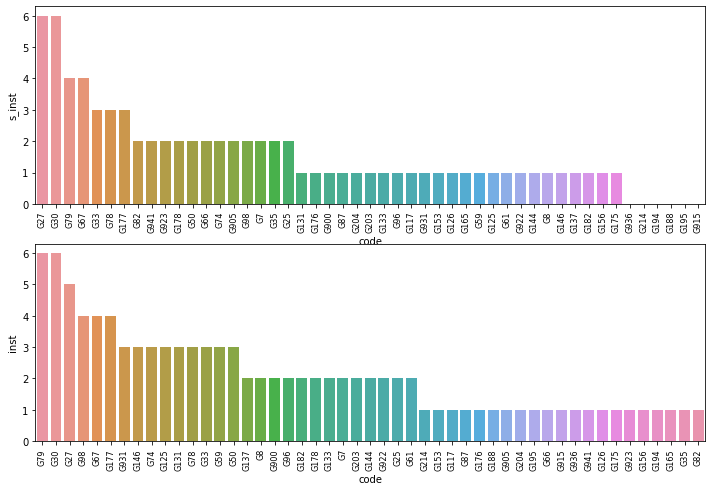

In [42]:
fig, axs = plt.subplots(2,1, figsize=(12,8))
sns.barplot(data=theta_codes.sort_values(by='s_inst', ascending=False), x='code', y='s_inst', ax=axs[0])
sns.barplot(data=theta_codes.sort_values(by='inst', ascending=False), x='code', y='inst', ax=axs[1])
axs[0].tick_params(axis='x', labelrotation=90, labelsize=8)
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

In [43]:
theta_samples_all = pd.DataFrame(index=codes_in_use)
tries = som_bassin_data.groupby(['code']).loc_date.nunique()
fails = som_bassin_data.groupby('code').fail.sum()
# tries_fails by water body

# for one body of water
#fails_b = som_bassin_data.groupby(['water_name','code']).fail.sum()

tries_fails = pd.concat([tries, fails], axis=1)
tries_fails['rate'] = tries_fails.fail/tries_fails.loc_date

code_weights = grtr_than_zero.groupby('code').weight.sum()

In [44]:
k = 0
for body in weights.index:
#     print(body)
#     print(tries_fails_b.loc[body].min_rate.sum())
    these_rates =tries_fails_b.loc[tries_fails_b.water_name == body][['code','min_rate']].set_index('code')
    

    for j in np.arange(weights.loc[body]['loc_date']):
        k+=1
        #print(j, k)
        col_name = F"s_{int(k)} {body}"
        for a_code in codes_in_use:
            theta_samples_all.loc[a_code, col_name ] = bernoulli.rvs(these_rates.loc[a_code], size=1)
#             theta_samples_all.loc[a_code, col_name ] = binom.rvs(1,these_rates.loc[a_code], size=1)
            

In [45]:
found = theta_samples_all > 0
codes_found = [found[found[s_one] == True][s_one].index for s_one in found.columns]
codes_found_len = [len(x) for x in codes_found]

print(len(codes_found[0]))
print(codes_found_len[0])
print(len(codes_found))

7
7
126


In [46]:
tries_fails.iloc[:3]

,loc_date,fail,rate
code,,,
G1,126,0,0.000000
G10,126,37,0.293651
G100,126,26,0.206349


In [47]:
# the number of unique codes per sample in the project data:
d_samps = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.nunique()

# the list of codes found at each survey in the project data:
d_samps_c = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [48]:
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
samp_codes = pd.DataFrame(count_occurences(d_samps_c)).set_index('code')


In [49]:
# a_list_o_list = [value for k, value in samples.items()]
# the_list_o_list = [*a_list_o_list]
theta_codes = pd.DataFrame(count_occurences(codes_found))
theta_codes['s_inst'] = theta_codes.code.map(lambda x: samp_codes.loc[x, 'inst'])
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

In [50]:
print(theta_codes['inst_dif'].sum())
print(len(theta_codes))
print(theta_codes.inst.sum(), theta_codes.s_inst.sum())

27
168
2927 2900


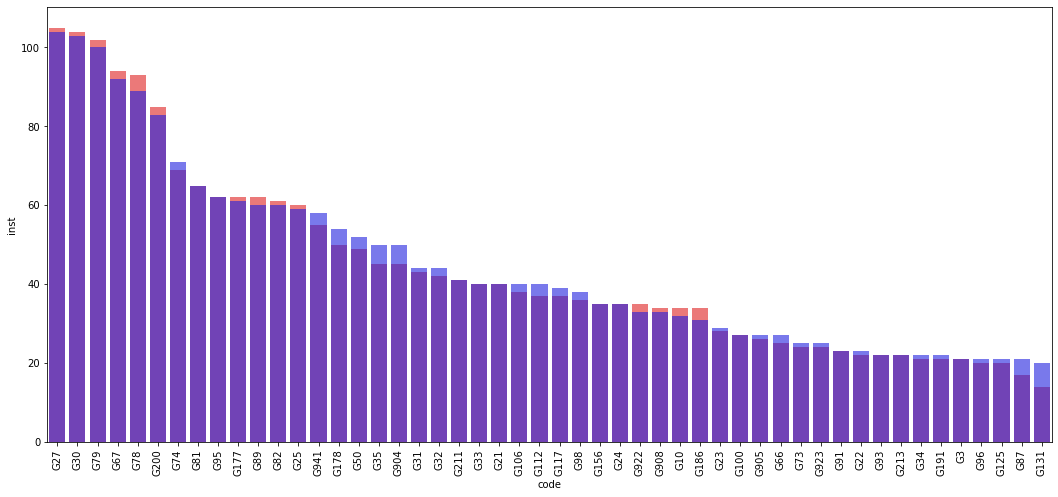

In [51]:
fig, axs = plt.subplots(figsize=(18,8))
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='s_inst', ascending=False), x='code', y='s_inst', color='red', alpha=.6, ax=axs)
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='inst', ascending=False), x='code', y='inst', color='blue',alpha=.6, ax=axs)
axs.tick_params(axis='x', labelrotation=90, labelsize=10)
# axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

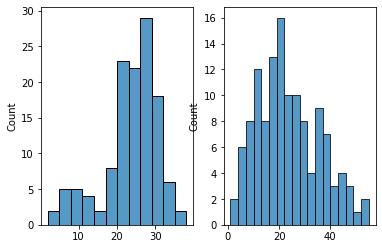

In [52]:

fig, axs = plt.subplots(1,2)
sns.histplot(codes_found_len, ax=axs[0], binwidth=3)
sns.histplot(d_samps.values, ax=axs[1], binwidth=3)
plt.show()
plt.close()

In [53]:
# found.rename(columns={x:x.split(" ")[-1] for x in found.columns}, inplace=True)
codes_found = [{'label':s_one.split(" ")[-1] , 'codes':found[found[s_one] == True][s_one].index.to_numpy()} for s_one in found.columns]
# codes_found_len = [len(x) for x in codes_found_feature]
a_label = codes_found[1]['label']
a_code = codes_found[1]['codes'][0]

In [54]:
location_weight = som_bassin_data.groupby('water_name', as_index=False).l_weight.median()
location_weight.loc[4, 'water_name'] = "Thièle"

In [55]:
agg_results_feature = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['water_name','code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_feature.columns = agg_results_feature.columns.get_level_values(1)
agg_results_bassin = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_bassin.columns = agg_results_bassin.columns.get_level_values(1)
# get the parameters for one code at one sample:
this_data = agg_results_feature.loc[a_label,codes_found[1]['codes'][0]]
print(this_data['mean'])
print(codes_found[1]['codes'][0])
print(a_label)
loc = this_data['mean']
alpha=this_data['min']
beta = 1/alpha
print("\n the parameters \n")
print(loc, alpha, beta)

print("\nthe predicted result \n")
print(gamma.rvs(alpha, loc=loc, scale=beta))

0.16
G175
Aare

 the parameters 

0.16 0.16 6.25

the predicted result 

0.16000001450162774


In [56]:
agg_results_feature.loc['Aare','G101']['min']

0.03

In [57]:
# hmm = pd.DataFrame(codes_found).explode('codes').copy()
# hmm.drop_duplicates(inplace=True)
# print(hmm.isnull().values.any())
# hmm.reset_index(inplace=True, drop=True)

In [58]:
def assign_params(a_label, a_code, a_param, params):
    default_params = agg_results_bassin
    try:
        this_param = params.loc[a_label,a_code][a_param]
    except:
        this_param = default_params.loc[a_code][a_param]
    return this_param
    

In [59]:
o_samps_d = b.bassin_pcsm_day[['water_name', 'pcs_m']].sort_values(by='pcs_m')
o_samps_d.reset_index(inplace=True, drop=True)
o_samps_d

,water_name,pcs_m
0,Aare,0.02
1,Aare,0.12
2,Aare,0.16
3,Thunersee,0.16
4,Aare,0.16
...,...,...
121,Bielersee,8.02
122,Bielersee,8.21
123,Bielersee,9.33
124,Bielersee,10.47


In [60]:
location_weight.set_index('water_name', drop=True, inplace=True)


In [61]:
location_weight

,l_weight
water_name,
Aare,0.007937
Aare|Nidau-Büren-Kanal,0.007937
Bielersee,0.087302
Brienzersee,0.015873
Thièle,0.007937
Neuenburgersee,0.087302
Schüss,0.015873
Thunersee,0.079365


In [62]:
sim_surveys = []
for i,sample in enumerate(codes_found):
    a_label = sample['label']
    som_codes = sample['codes']
    loc_weight = location_weight.loc[a_label]
    for a_code in som_codes:
        alpha = assign_params(a_label, a_code, 'median', agg_results_feature)
        loc = assign_params(a_label, a_code, 'min', agg_results_feature)
        scale = assign_params(a_label, a_code, 'max', agg_results_feature)+(5*alpha)       
        pcs_m = gamma.rvs(alpha+(loc_weight*alpha), loc=loc, scale=scale)
        sim_surveys.append({'code':a_code, 'label':a_label, 'survey':i, 'pcs_m':pcs_m})
    
new_surveys = pd.DataFrame(sim_surveys)
new_surveys_d = new_surveys.groupby(['survey','label'], as_index=False).pcs_m.sum().copy()

new_surveys_d.sort_values(by='pcs_m', inplace=True)
ns_d = new_surveys_d[['label', 'pcs_m']].reset_index(drop=True).copy()
ns_d.rename(columns={'label':'water_name'}, inplace=True)
ns_d['label'] = 'sim'
o_samps_d['label'] = 'odata'
o_samps_d['survey'] = o_samps_d.index
ns_d['survey'] =ns_d.index

In [63]:
o_samps_d['label'] = 'odata'

combined = pd.concat([ns_d, o_samps_d])

In [64]:
combined

,water_name,pcs_m,label,survey
0,Thièle,0.115766,sim,0
1,Aare,0.161204,sim,1
2,Neuenburgersee,0.211074,sim,2
3,Thunersee,0.251449,sim,3
4,Aare,0.267640,sim,4
...,...,...,...,...
121,Bielersee,8.020000,odata,121
122,Bielersee,8.210000,odata,122
123,Bielersee,9.330000,odata,123
124,Bielersee,10.470000,odata,124


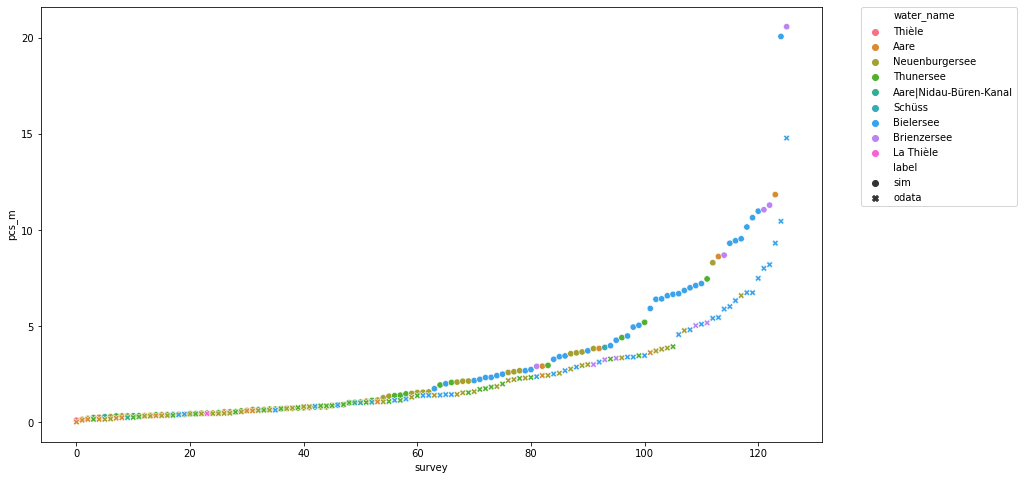

In [65]:
fig, axs = plt.subplots(figsize=(14,8))
sns.scatterplot(data=combined, x='survey', y='pcs_m', style='label', hue='water_name', palette='husl', s=40, ax=axs)
# sns.scatterplot(data=o_samps_d, x=o_samps_d.index, y=o_samps_d.pcs_m, hue=o_samps_d.water_name, palette='viridis', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

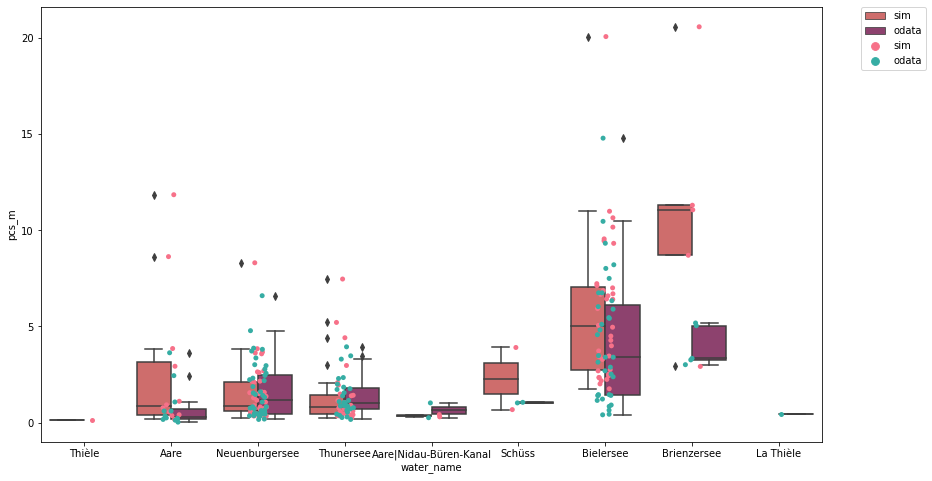

In [66]:
# get the values for one survey:
fig, axs = plt.subplots(figsize=(14,8))
sns.boxplot(data=combined, x='water_name', y='pcs_m', hue='label', palette='flare', ax=axs, dodge=True)
sns.stripplot(data=combined, x='water_name', y='pcs_m', hue='label', palette='husl', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


In [67]:
hmm

NameError: name 'hmm' is not defined

In [ ]:
these_params = []

# get some paramaters from the data.
print("The codes and the number of samples that the parameters are being drawn from\n")
for code in samples[0]:
    samp_data = som_params[som_params.code == code].pcs_m
    # check how many samples there are for this region/district
    # if less than minsamps grab the results from the next highest level
    minsamps = 65
    if len(samp_data) < minsamps:
        samp_data = a.processed[(a.processed.code == code)&(a.processed.quantity > 0)].pcs_m
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    else:
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    print(code, len(samp_data))
    these_params.append(dict(code=code, loc=loc, alpha=alpha, scale=scale, data=samp_data))


In [ ]:
these_params[2]['data'].sum()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch